In [1]:
import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder

assert numpyro.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
import geopandas as gpd
plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [3]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [4]:
df = df[df.date > '2021-10-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x == 'BA.1')))
all = df.groupby(['sending_pc','date'])['omi'].count()
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy().dropna()
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)

df_filtered = df_filtered.merge(bland, left_on='sending_pc', right_index=True)#.dropna()
df_filtered['bundesland'] = pd.Categorical(df_filtered['bundesland'].values)

omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['bundesland'].values.codes

In [5]:
df_filtered

sending_pc       date  all  omi  days  sending_area  sending_pc_ID  \
0          01067 2021-10-02    0    0  -101             0              0   
1          01067 2021-10-03    0    0  -100             0              0   
2          01067 2021-10-04    0    0   -99             0              0   
3          01067 2021-10-05   11    0   -98             0              0   
4          01067 2021-10-06    0    0   -97             0              0   
...          ...        ...  ...  ...   ...           ...            ...   
24410      90530 2021-12-31    0    0   -11             9             92   
24411      90530 2022-01-01    0    0   -10             9             92   
24412      90530 2022-01-02    0    0    -9             9             92   
24413      90530 2022-01-03    0    0    -8             9             92   
24414      90530 2022-01-04    0    0    -7             9             92   

      bundesland  
0        Sachsen  
1        Sachsen  
2        Sachsen  
3        Sachsen  
4        Sachsen  
...          ...  
24410     Bayern  
24411     Bayern  
24412     Bayern  
24413     Bayern  
24414     Bayern  

[10355 rows x 8 columns]

(18951.0, 19003.0)

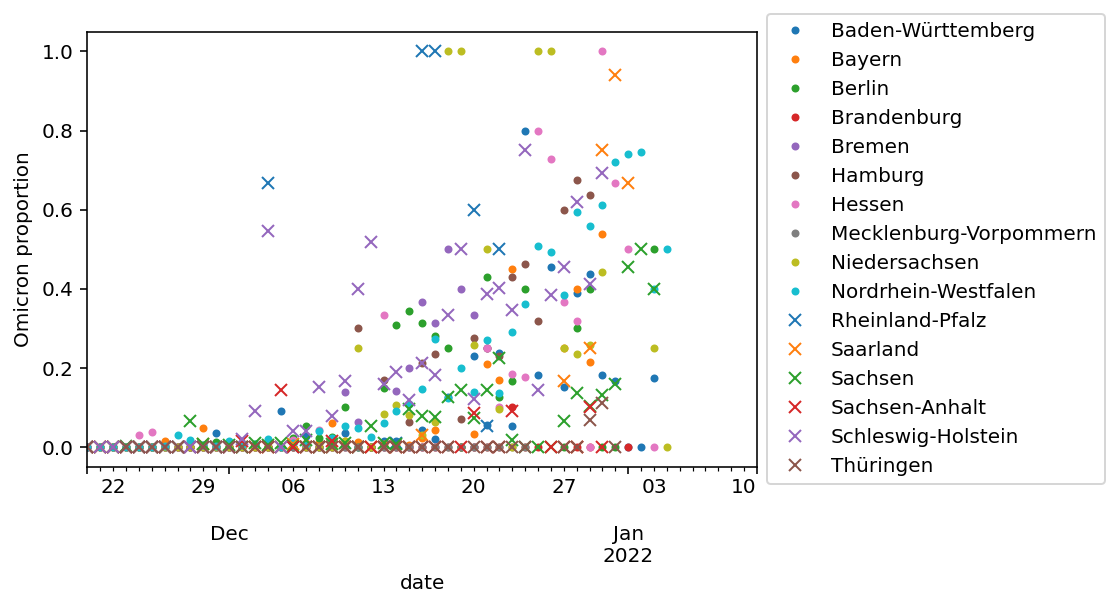

In [63]:
omi_bl = df_filtered.set_index(['bundesland','sending_pc','date']).sort_index()
omi_bl = omi_bl.sum(level=[0,2]).loc[:,"2021-11-20":,:]
omi_bl['prop'] = omi_bl.omi / omi_bl['all']
for i,r in enumerate(omi_bl.index.levels[0]):
    omi_bl.loc[r]['prop'].plot(ls="", marker="." if i < 10 else "x", label=r)
#omi_bl.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.yscale('logit')
plt.ylabel("Omicron proportion")
plt.xlim((None, np.datetime64("today")))

In [51]:
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {k: LocScaleReparam(0) for k in ["mu_a", "a"]}

#@numpyro.handlers.reparam(config=reparam_config)
def model3(sending_pc, sending_area, sending_pc_to_area, sample_day, total_counts,omi_counts=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0, 5.0))
    sigma_a_area = numpyro.sample("sigma_a_area", dist.HalfNormal(5.0))
    sigma_a_lab = numpyro.sample("sigma_a_lab", dist.HalfNormal(2.0))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.2, 0.2))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(.1))


    n_labs = len(np.unique(sending_pc))
    n_areas = len(np.unique(sending_pc_to_area))

    with numpyro.plate("plate_i", n_areas):
        a_area = numpyro.sample("a_area", dist.Normal(mu_a, sigma_a_area))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))

    with numpyro.plate("plate_j", n_labs):
        a_lab = numpyro.sample("a_lab", dist.Normal(0, sigma_a_lab)) 
    
    logit_est = a_lab[sending_pc] + a_area[sending_area] + b[sending_area] * sample_day

    with numpyro.plate("data", len(sending_pc)):
        numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)


In [52]:
sending_pc_to_area = pd.DataFrame({"sending_pc": sending_pc_ID, "sending_area": sending_area}).groupby(['sending_pc']).sending_area.first().values

In [53]:
nuts_kernel = NUTS(model3)

mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sending_pc_ID, sending_area, sending_pc_to_area, sample_day, total_counts, omi_counts=omi_counts)

sample: 100%|██████████| 7000/7000 [38:09<00:00,  3.06it/s, 1023 steps of size 4.45e-03. acc. prob=0.76]  


In [54]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     a_area[0]      0.97      0.47      0.98      0.26      1.78    722.19      1.00
     a_area[1]      2.26      0.56      2.24      1.38      3.22   1373.26      1.00
     a_area[2]      2.94      0.74      2.93      1.69      4.12    877.35      1.00
     a_area[3]      0.58      1.20      0.70     -1.28      2.51   1032.04      1.00
     a_area[4]      3.39      1.05      3.33      1.60      4.99    937.70      1.00
     a_area[5]      3.15      0.64      3.15      2.10      4.21    558.33      1.01
     a_area[6]      1.50      0.68      1.53      0.40      2.63   1238.17      1.00
     a_area[7]      0.13      1.44      0.27     -2.06      2.42    896.64      1.00
     a_area[8]      2.03      0.54      2.03      1.12      2.89   1203.80      1.00
     a_area[9]      2.16      0.35      2.16      1.57      2.69    519.40      1.00
    a_area[10]      2.45      0.94      2.41      0.87      3.94

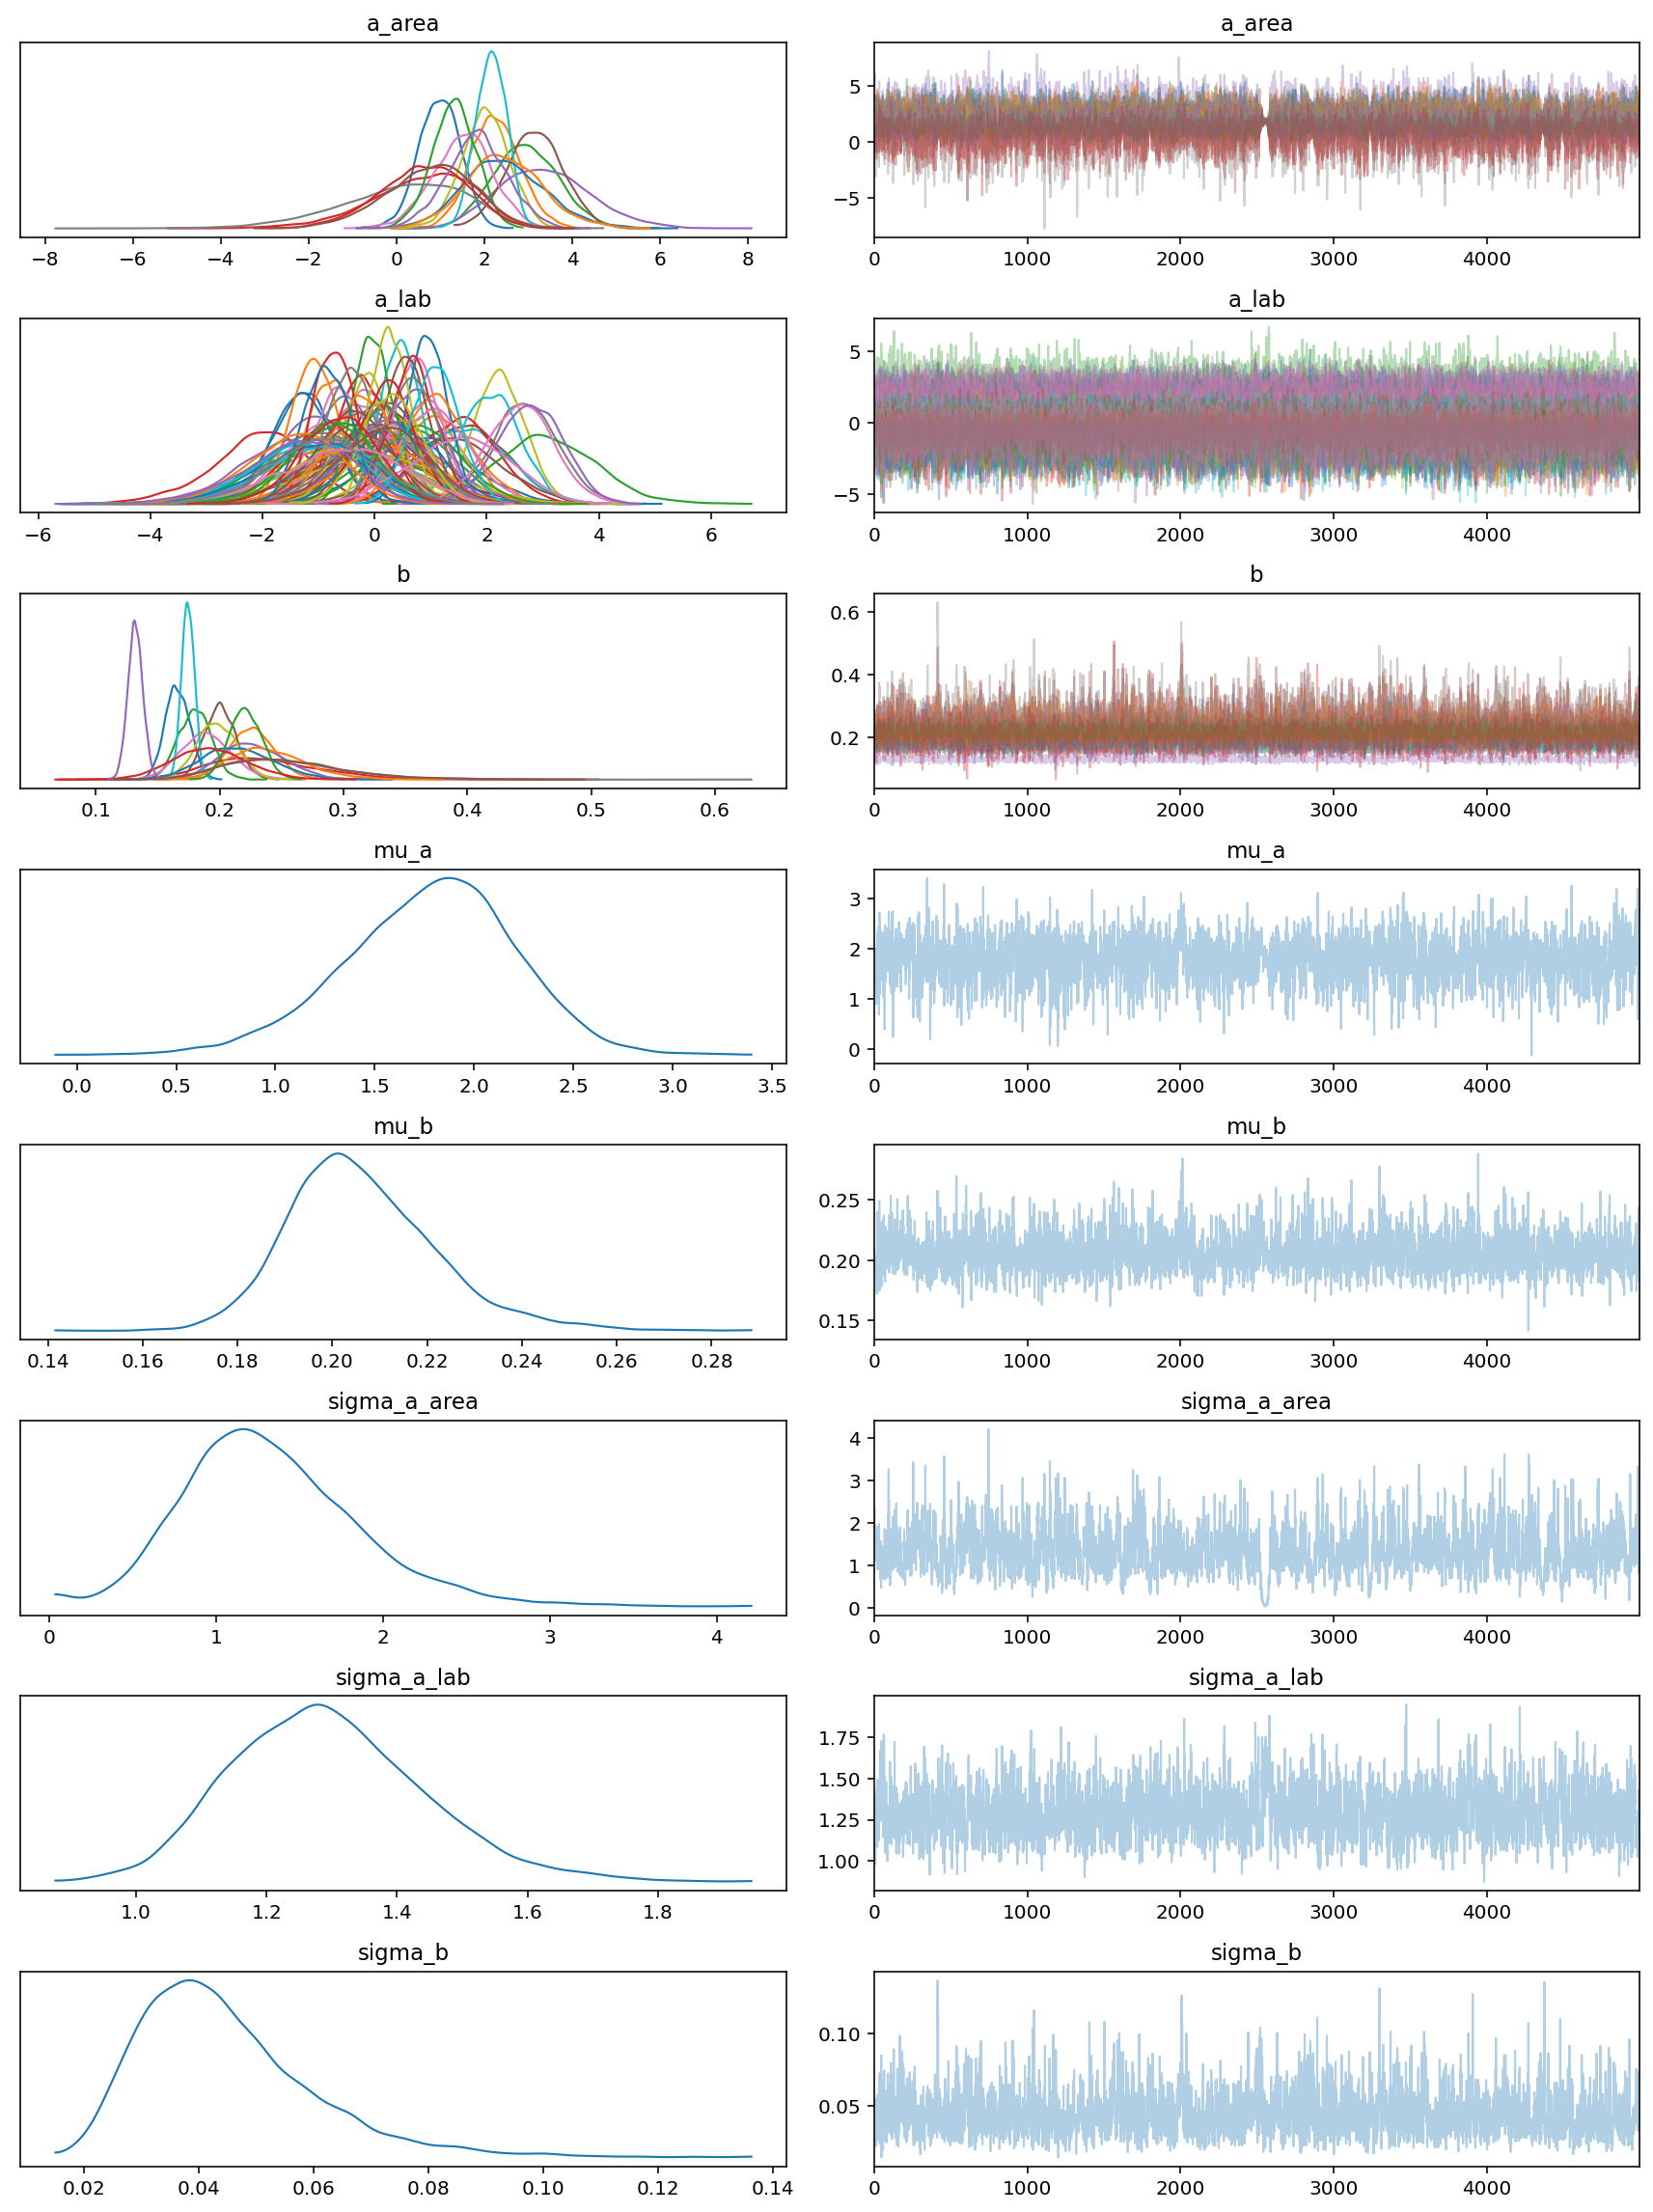

In [55]:
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [176]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)
s = numpyro.diagnostics.summary(mcmc_samples)

print(f"""
    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    {np.exp(s['mu_b']['mean'])-1:.1%} mit 90%-Konfidenzintervall [{np.exp(s['mu_b']['5.0%'])-1:.1%}, {np.exp(s['mu_b']['95.0%'])-1:.1%}]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    {np.log(2)/np.log(1+s['mu_b']['mean']):.2} Tage mit 90%-Konfidenzintervall [{np.log(2)/np.log(1+s['mu_b']['95.0%']):.2},{np.log(2)/np.log(1+s['mu_b']['5.0%']):.2}]
    """)


    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    22.9% mit 90%-Konfidenzintervall [19.9%, 26.0%]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    3.7 Tage mit 90%-Konfidenzintervall [3.3,4.2]
    


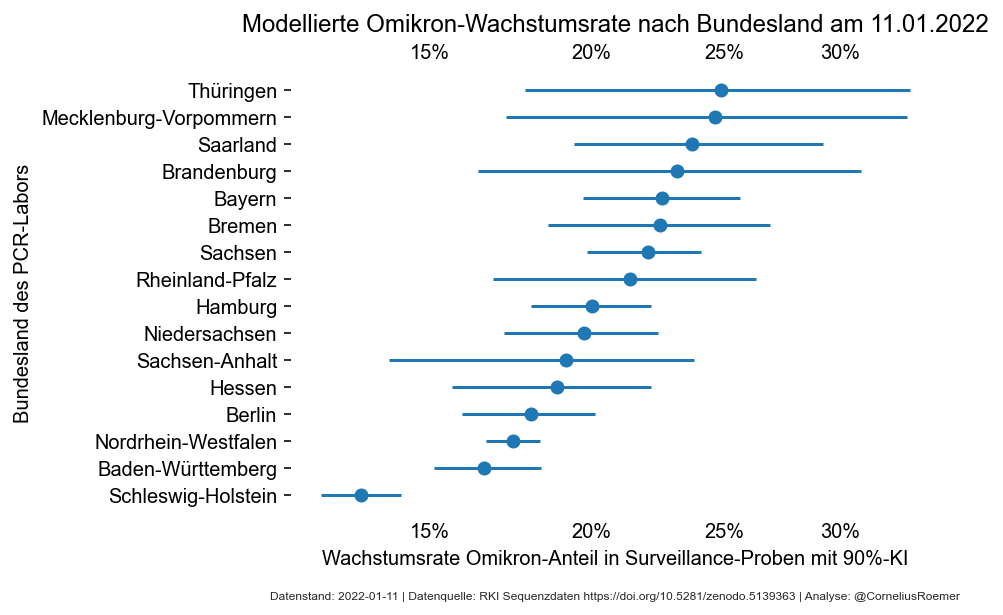

In [57]:
nice_formatter = ticker.FuncFormatter(
    lambda y, _: f'{ np.format_float_positional(100*y, trim="-", precision=6).rstrip(".")}%'
)
pdf = pd.DataFrame(s['b'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([(pdf['median'])-(pdf['5.0%']),(pdf['95.0%'])-(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
sns.set_theme(style="whitegrid")
ax.errorbar(x=(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierte Omikron-Wachstumsrate nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Wachstumsrate Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [58]:
list(df_filtered.bundesland.values.categories)

['Baden-Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen']

In [64]:
q = [0.05,0.5,0.95]
t = (np.arange("2021-12-01","2022-01-31", dtype='datetime64[D]') - np.datetime64("today")).astype("int")
prop_bl = pd.Series(expit(np.quantile(mcmc_samples['a_area'][0][...,np.newaxis] + mcmc_samples['b'][0][...,np.newaxis] * t[np.newaxis,np.newaxis,:], 
                                     q,
                                     axis = 0)).flatten(),
                         index = pd.MultiIndex.from_product([q, 
                                                             df_filtered.bundesland.values.categories,
                                                             np.datetime64("today") + t.astype("timedelta64[D]")],
                                                           names=['quantile',
                                                                  'bundesland',
                                                                  'date']),
                       )
prop_bl = prop_bl.reset_index().set_index(["bundesland","date","quantile"])#.pivot(columns="quantile")

In [65]:
prop_bl

0
bundesland        date       quantile          
Baden-Württemberg 2021-12-01 0.05      0.001407
                  2021-12-02 0.05      0.001670
                  2021-12-03 0.05      0.001974
                  2021-12-04 0.05      0.002347
                  2021-12-05 0.05      0.002788
...                                         ...
Thüringen         2022-01-26 0.95      0.999202
                  2022-01-27 0.95      0.999434
                  2022-01-28 0.95      0.999594
                  2022-01-29 0.95      0.999716
                  2022-01-30 0.95      0.999796

[2928 rows x 1 columns]

In [66]:
omi_bl.loc[r]['prop']

date
2021-11-20    0.000000
2021-11-21         NaN
2021-11-22         NaN
2021-11-23    0.000000
2021-11-24    0.000000
2021-11-25    0.000000
2021-11-26    0.000000
2021-11-27    0.000000
2021-11-28         NaN
2021-11-29    0.000000
2021-11-30    0.000000
2021-12-01    0.000000
2021-12-02    0.000000
2021-12-03    0.000000
2021-12-04    0.000000
2021-12-05         NaN
2021-12-06         NaN
2021-12-07    0.000000
2021-12-08    0.000000
2021-12-09    0.000000
2021-12-10    0.000000
2021-12-11    0.000000
2021-12-12         NaN
2021-12-13    0.000000
2021-12-14    0.000000
2021-12-15    0.000000
2021-12-16    0.000000
2021-12-17    0.000000
2021-12-18    0.000000
2021-12-19         NaN
2021-12-20    0.000000
2021-12-21    0.000000
2021-12-22    0.000000
2021-12-23    0.000000
2021-12-24    0.000000
2021-12-25         NaN
2021-12-26         NaN
2021-12-27    0.000000
2021-12-28    0.000000
2021-12-29    0.066667
2021-12-30    0.111111
2021-12-31    0.000000
2022-01-01         NaN
2022-0

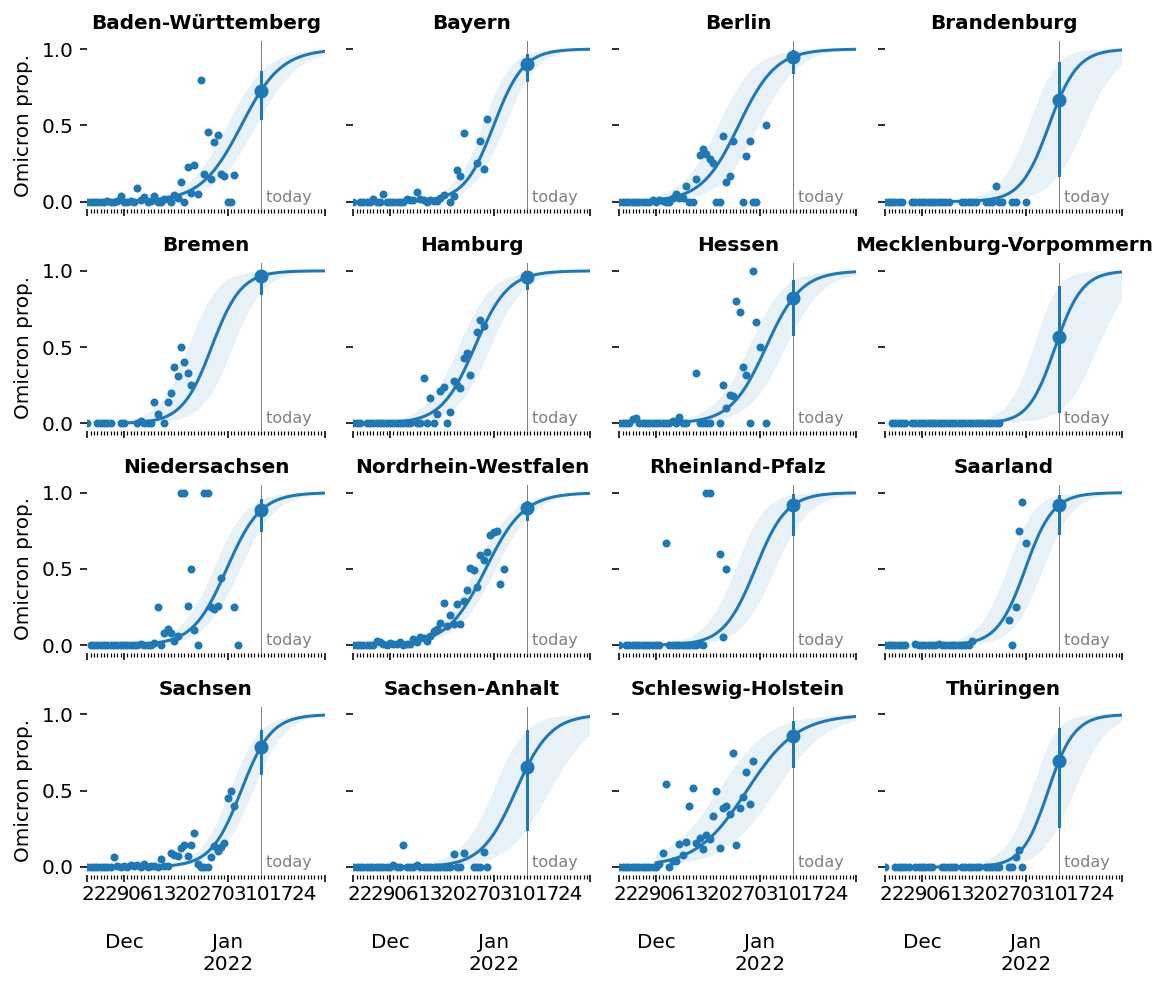

In [172]:
sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    prop_bl.loc[r,:,0.5][0].plot(label=r, ax=ax[i])
    ax[i].fill_between(prop_bl.loc[r,:,0.05][0].index, prop_bl.loc[r,:,0.05][0], prop_bl.loc[r,:,0.95][0], alpha=0.1)
    ax[i].axvline(np.datetime64("today"), color='grey', lw=0.5)
    ax[i].text(np.datetime64("today"),0.0, " today", size=8, color='grey')
    ax[i].plot(np.repeat(np.datetime64("today"),2), prop_bl.loc[r,np.datetime64("today"),[0.05,0.95]], c='C0')
    ax[i].scatter(np.datetime64("today"), prop_bl.loc[r,np.datetime64("today"),0.5], c='C0')
    ax[i].grid(ls=":")
    omi_bl.loc[r]['prop'].plot(ls="", marker=".", label=r, ax=ax[i], c='C0')
    ax[i].set_title(r, size=10, weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Omicron prop.")

    for a in ax[i].spines.values():
        a.set_visible(False)
plt.tight_layout()
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

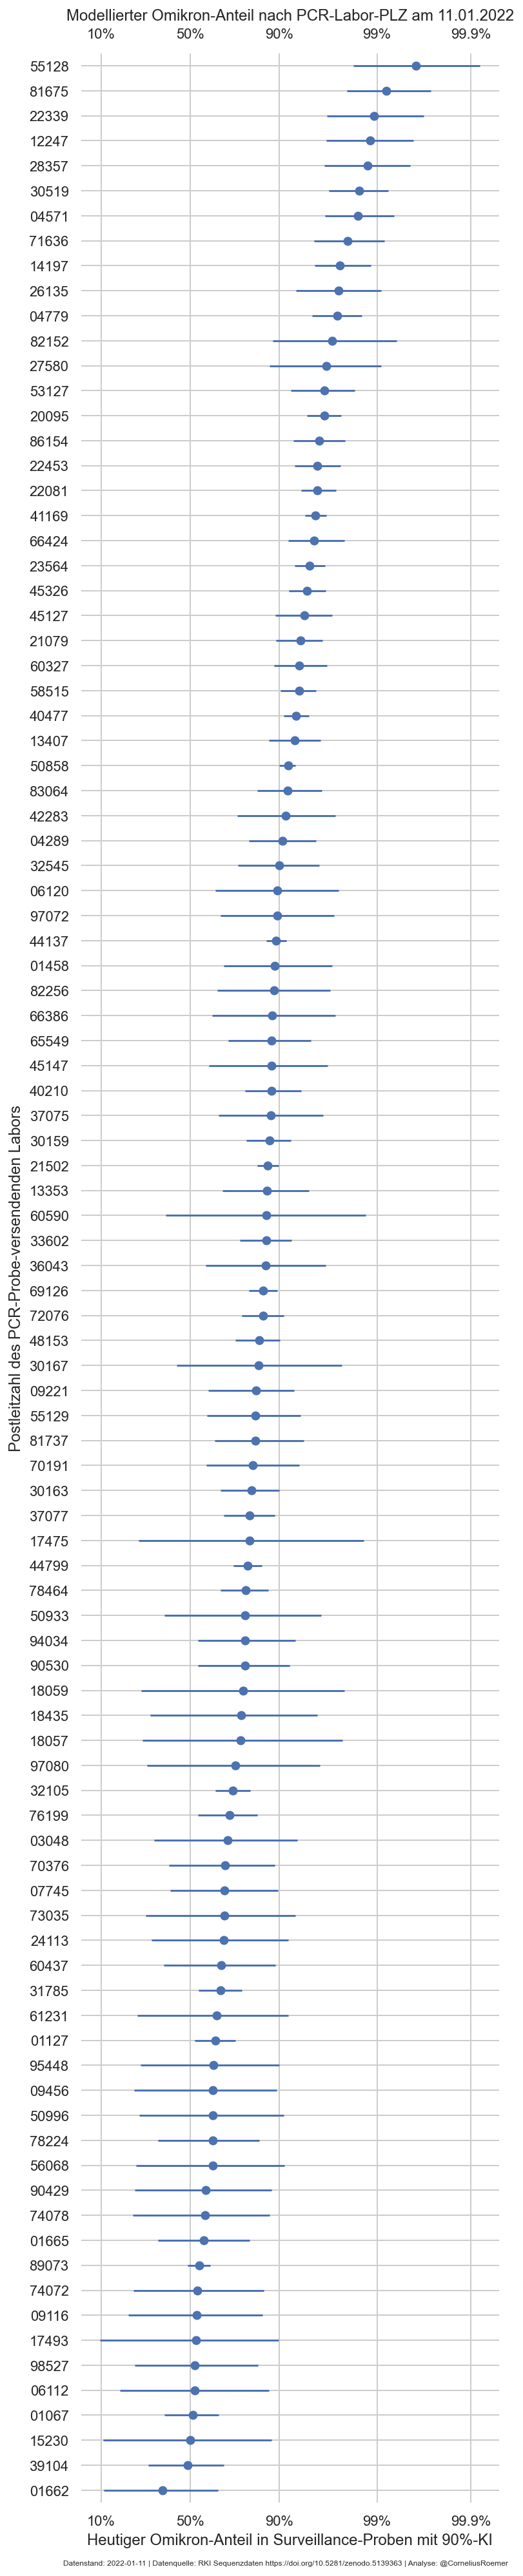

In [18]:
pdf = pd.DataFrame(s['a'])
pdf['plz'] = le.inverse_transform(pdf.index.values)
pdf.set_index('plz',inplace=True)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(5,30)) 
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values,xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.set(title=f'Modellierter Omikron-Anteil nach PCR-Labor-PLZ am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Postleitzahl des PCR-Probe-versendenden Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.02)
fig.text(0.49, -0.003, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_pc.png",dpi=300,bbox_inches='tight',pad_inches=0.2)

Es gibt drei klare Ausreißer die entfernt wurden. Für mehr Details zu Outliern siehe das Notebook [Outlier Labs](outlier_labs.ipynb).

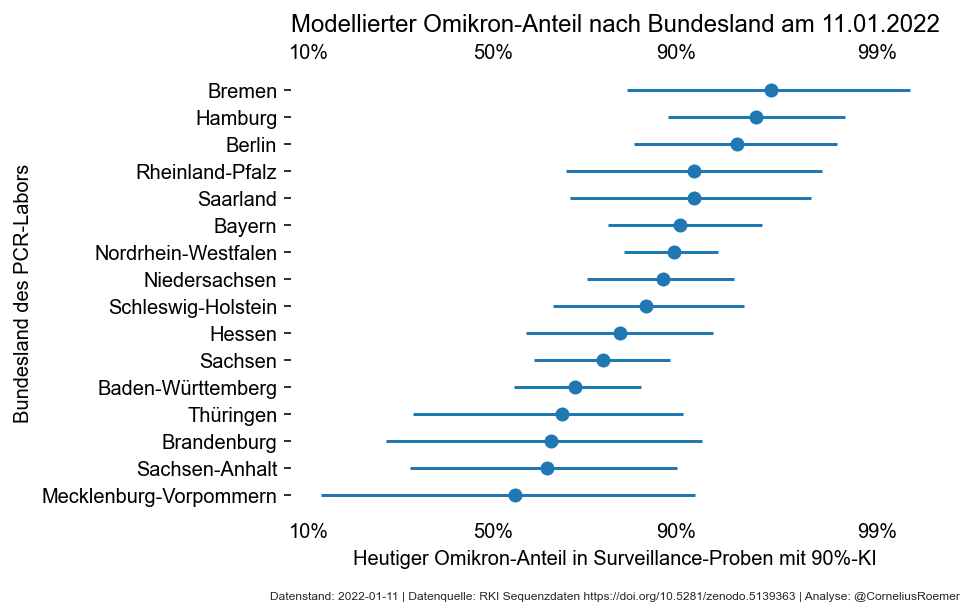

In [68]:
pdf = pd.DataFrame(s['a_area'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
sns.set_theme(style="whitegrid")
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierter Omikron-Anteil nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
#fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [20]:
bl = plz.dissolve(by = 'bundesland')
bl.geometry = bl.simplify(1e-2, preserve_topology=False)

In [21]:
bl['land'] = "Deutschland"

In [22]:
bl

geometry  \
bundesland                                                                  
#N/A                    POLYGON ((6.83623 49.21127, 6.85915 49.22275, ...   
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...   
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...   
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...   
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...   
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...   
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...   
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...   
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...   
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...   
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...   
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...   
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...   
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...   
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...   
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...   
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...   

                        OBJECTID    plz       ags                ort  \
bundesland                                                             
#N/A                         409  57540      #N/A               #N/A   
Baden-Württemberg           1129  79588  08336014   Efringen-Kirchen   
Bayern                      3150  63791  09671114  Karlstein am Main   
Berlin                      8042  14109  11000000             Berlin   
Brandenburg                 6380  19309  12070236               Lanz   
Bremen                      2400  28777  04011000             Bremen   
Hamburg                     2308  27499  02000000            Hamburg   
Hessen                      1486  65391  06439010              Lorch   
Mecklenburg-Vorpommern      5574  19258  13076009        Bengerstorf   
Niedersachsen                253  26757  03457002             Borkum   
Nordrhein-Westfalen            1  52538  05370008            Gangelt   
Rheinland-Pfalz               24  54689  07232001             Affler   
Saarland                      92  66706  10042115               Perl   
Sachsen                     7046  08538  14523450         Weischlitz   
Sachsen-Anhalt              5540  38835  15085230         Osterwieck   
Schleswig-Holstein          1625  27498  01056025          Helgoland   
Thüringen                   4517  36419  16063011            Buttlar   

                                            landkreis  einwohner  \
bundesland                                                         
#N/A                                             #N/A        0.0   
Baden-Württemberg                   Landkreis Lörrach     8205.0   
Bayern                        Landkreis Aschaffenburg     8023.0   
Berlin                                           None    10049.0   
Brandenburg                        Landkreis Prignitz     3684.0   
Bremen                                           None    12969.0   
Hamburg                                          None        8.0   
Hessen                          Rheingau-Taunus-Kreis     3994.0   
Mecklenburg-Vorpommern  Landkreis Ludwigslust-Parchim    15989.0   
Niedersachsen                          Landkreis Leer     5207.0   
Nordrhein-Westfalen                   Kreis Heinsberg    21390.0   
Rheinland-Pfalz               Eifelkreis Bitburg-Prüm     2326.0   
Saarland                      Landkreis Merzig-Wadern     7791.0   
Sachsen                                 Vogtlandkreis     6264.0   
Sachsen-Anhalt                         Landkreis Harz    10404.0   
Schleswig-Holstein                    Kreis Pinneberg     1407.0   
Thüringe

In [23]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


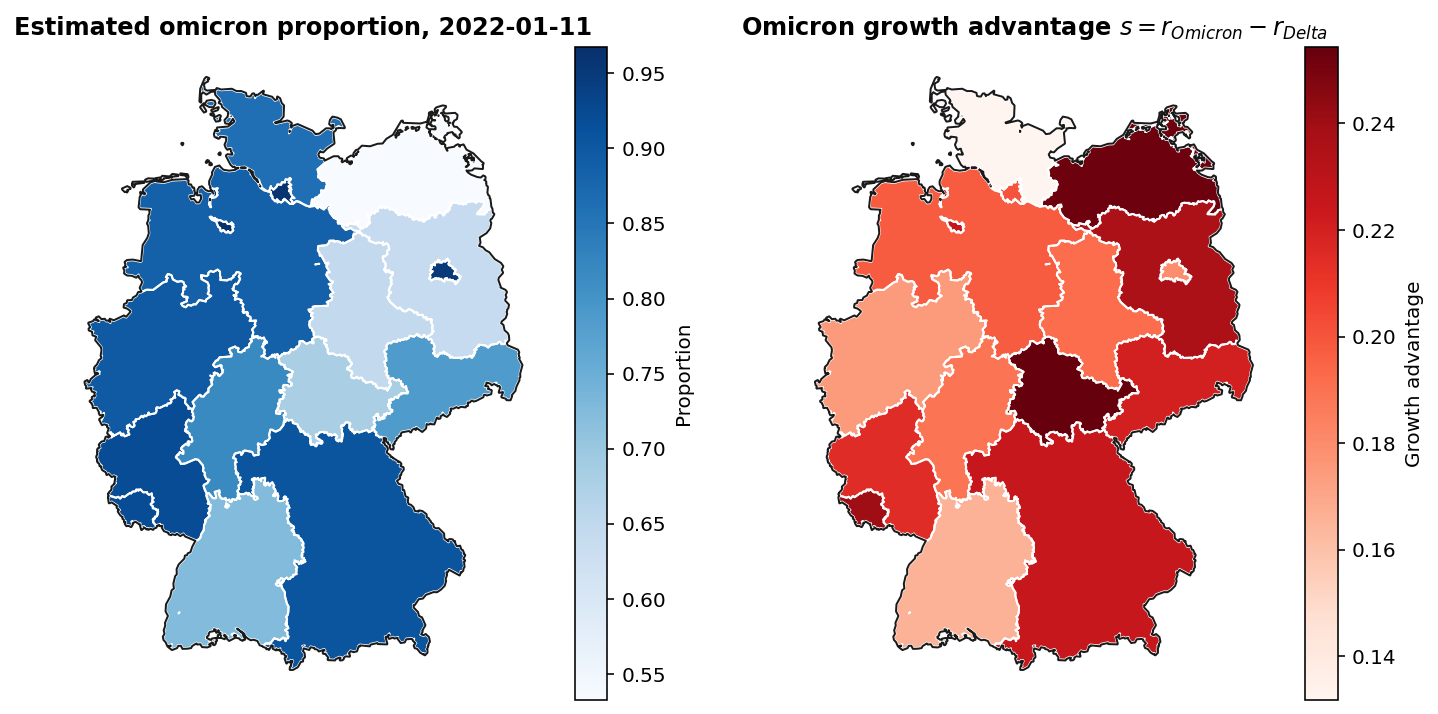

In [177]:
#sns.set_style("white")
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.flatten()
sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
pdf = pd.DataFrame({'prop':expit(s['a_area']['mean']),
                    'prop_5%':expit(s['a_area']['5.0%']),
                    'prop_95%':expit(s['a_area']['95.0%']),
                    's': s['b']['mean'],
                    's_sd': s['b']['std']},
                   index=df_filtered.bundesland.values.categories)

b = bl.merge(pdf, left_index=True, right_index=True)
b.plot("prop", lw=1, cmap="Blues", 
            legend=True,
            legend_kwds={'label': "Proportion"},
            figsize=(6,6),
       ax = ax[0]
           )
#bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
#bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())


b.boundary.plot(color='w',lw=1, ax=ax[0])
de.boundary.plot(color='k',lw=1, ax=ax[0])

ax[0].axis('off')
ax[0].set_title(f"Estimated omicron proportion, {np.datetime64('today')}", weight='bold')

b.plot("s", lw=1, cmap="Reds", 
            legend=True,
            legend_kwds={'label': "Growth advantage"},
            figsize=(6,6),
       ax = ax[1]
           )
b.boundary.plot(color='w',lw=1, ax=ax[1])
de.boundary.plot(color='k',lw=1,  ax=ax[1])

ax[1].axis('off')
ax[1].set_title("Omicron growth advantage $s = r_{Omicron} - r_{Delta}$", weight='bold')
fig.savefig("plots/omi_share_map.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [72]:
bar = omi_bl.reset_index()
bar['week'] = bar.date - pd.to_timedelta(bar.date.dt.dayofweek, unit='d')
bar = bar.set_index(['bundesland', 'week','date']).sum(level=(0,1))
bar['prop'] = bar.omi/bar['all']
bar['prop']

bundesland         week      
Baden-Württemberg  2021-11-15    0.000000
                   2021-11-22    0.000652
                   2021-11-29    0.006645
                   2021-12-06    0.009434
                   2021-12-13    0.016925
                                   ...   
Thüringen          2021-12-06    0.000000
                   2021-12-13    0.000000
                   2021-12-20    0.000000
                   2021-12-27    0.068493
                   2022-01-03         NaN
Name: prop, Length: 128, dtype: float64

(2707.0, 2716.0)

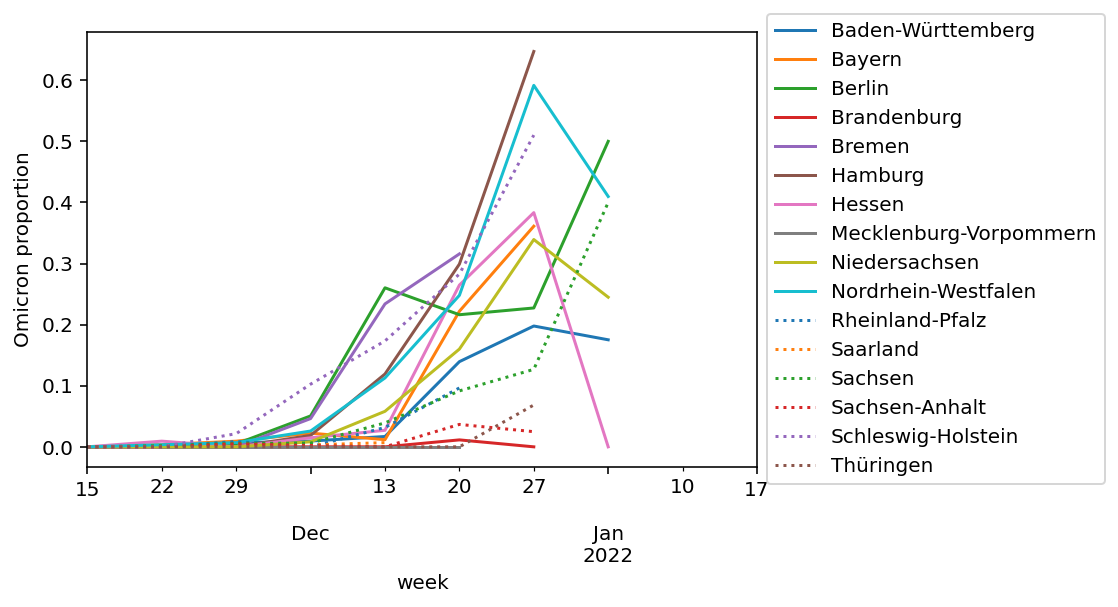

In [73]:
for i,r in enumerate(bar.index.levels[0]):
    bar.loc[r]['prop'].plot( label=r, ls = "-" if i <10 else ":")
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Omicron proportion")
plt.xlim((None,np.datetime64("today")))

In [74]:
bar.loc[:,'2021-12-20':,:]

all  omi  days  sending_area  \
bundesland             week                                       
Baden-Württemberg      2021-12-20  373   52 -1596           588   
                       2021-12-27  622  123 -1008           588   
                       2022-01-03  137   24  -180           168   
Bayern                 2021-12-20  347   77 -1596           714   
                       2021-12-27   36   13 -1008           714   
                       2022-01-03    0    0  -180           204   
Berlin                 2021-12-20   37    8  -532            28   
                       2021-12-27   22    5  -336            28   
                       2022-01-03    2    1   -60             8   
Brandenburg            2021-12-20   88    1  -266             7   
                       2021-12-27    6    0  -168             7   
                       2022-01-03    0    0   -30             2   
Bremen                 2021-12-20   19    6  -266            28   
                       2021-12-27    0    0  -168            28   
                       2022-01-03    0    0   -30             8   
Hamburg                2021-12-20  321   96  -931            98   
                       2021-12-27  204  132  -588            98   
                       2022-01-03    0    0  -105            28   
Hessen                 2021-12-20  102   27  -665           189   
                       2021-12-27   60   23  -420           189   
                       2022-01-03    1    0   -75            54   
Mecklenburg-Vorpommern 2021-12-20  103    0 -1064            56   
                       2021-12-27    0    0  -672            56   
                       2022-01-03    0    0  -120            16   
Niedersachsen          2021-12-20  150   24 -1197           182   
                       2021-12-27  112   38  -756           182   
                       2022-01-03   49   12  -135            52   
Nordrhein-Westfalen    2021-12-20  984  244 -2527           546   
                       2021-12-27  644  381 -1596           546   
                       2022-01-03  144   59  -285           156   
Rheinland-Pfalz        2021-12-20   83    8  -399           105   
                       2021-12-27    0    0  -252           105   
                       2022-01-03    0    0   -45            30   
Saarland               2021-12-20    0    0  -266            84   
                       2021-12-27   78   45  -168            84   
                       2022-01-03    0    0   -30            24   
Sachsen                2021-12-20  677   62 -1729             0   
                       2021-12-27  276   35 -1092             0   
                       2022-01-03   25   10  -195             0   
Sachsen-Anhalt         2021-12-20  109    4  -399            21   
                       2021-12-27  121    3  -252            21   
                       2022-01-03    0    0   -45             6   
Schleswig-Holstein     2021-12-20  336   95  -532            56   
                       2021-12-27  343  175  -336            56   
                       2022-01-03    0    0   -60            16   
Thüringen              2021-12-20  166    0  -532           189   
                       2021-12-27   73    5  -336           189   
                       2022-01-03    0    0   -60            54   

                                   sending_pc_ID      prop  
bundesland             week                                 
Baden-Württemberg      2021-12-20           6636  0.139410  
                       2021-12-27           6636  0.197749  
                       2022-01-03           1896  0.175182  
Bayern                 2021-12-20           7560  0.221902  
                       2021-12-27           7560  0.361111  
                       2022-01-03           2160       NaN  
Berlin                 2021-12-20            462  0.216216  
                       2021-12-27            462  0.227273  
                       2022-01-03            132  0.500000  
Brandenburg  

In [75]:
cases = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [76]:
cases = cases['AnzahlFall'].sum(level=(0,3)).sort_index()

In [77]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [78]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-06         667
                  2022-01-07         492
                  2022-01-08         403
                  2022-01-09         214
                  2022-01-10         151

[11141 rows x 1 columns]

Text(0, 0.5, 'cases')

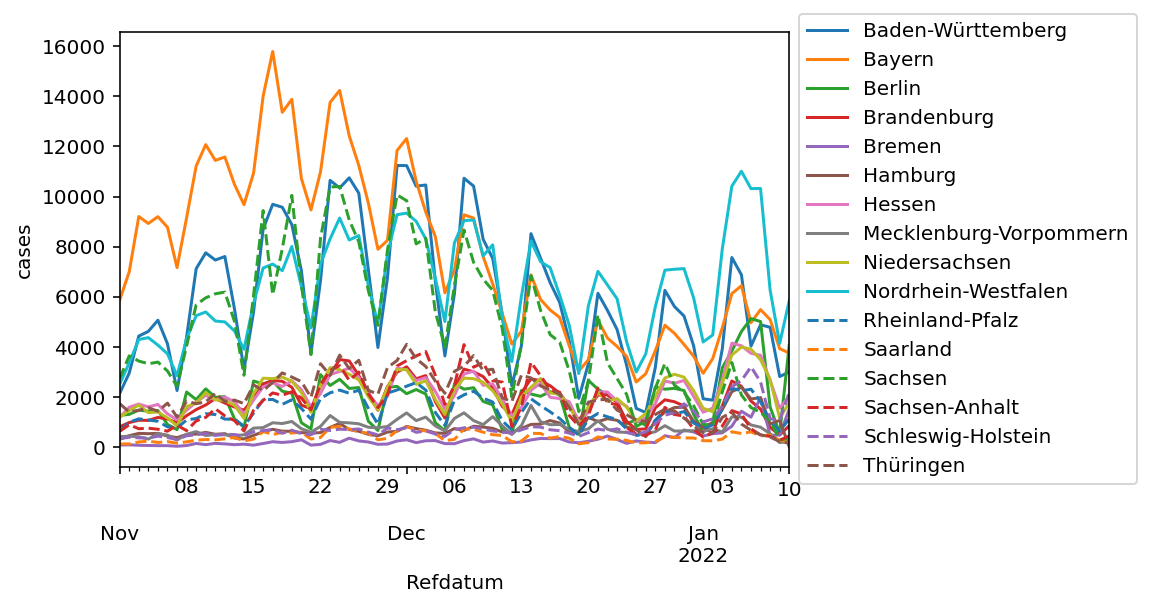

In [79]:
for i,r in enumerate(cases_land.index.levels[0]):
    cases_land.loc[r].loc["2021-11-01":,'AnzahlFall'].plot(label=r, ls="-" if i<10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel('cases')
#plt.xlim("")

In [80]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   211    0 -1236           168           1896   
                  2021-11-22  1533    1 -3948           588           6636   
                  2021-11-29   903    6 -3360           588           6636   
                  2021-12-06   954    9 -2772           588           6636   
                  2021-12-13   709   12 -2184           588           6636   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-06   143    0  -924           189           2135   
                  2021-12-13   240    0  -728           189           2135   
                  2021-12-20   166    0  -532           189           2135   
                  2021-12-27    73    5  -336           189           2135   
                  2022-01-03     0    0   -60            54            610   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000652  
                  2021-11-29  0.006645  
                  2021-12-06  0.009434  
                  2021-12-13  0.016925  
...                                ...  
Thüringen         2021-12-06  0.000000  
                  2021-12-13  0.000000  
                  2021-12-20  0.000000  
                  2021-12-27  0.068493  
                  2022-01-03       NaN  

[128 rows x 6 columns]

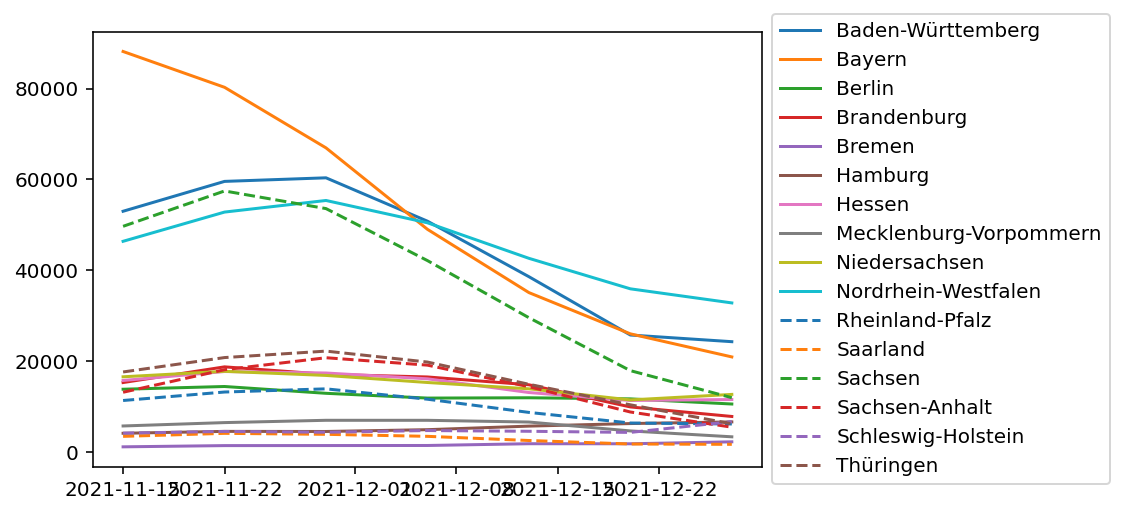

In [81]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] , label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Text(0, 0.5, 'Omicron cases')

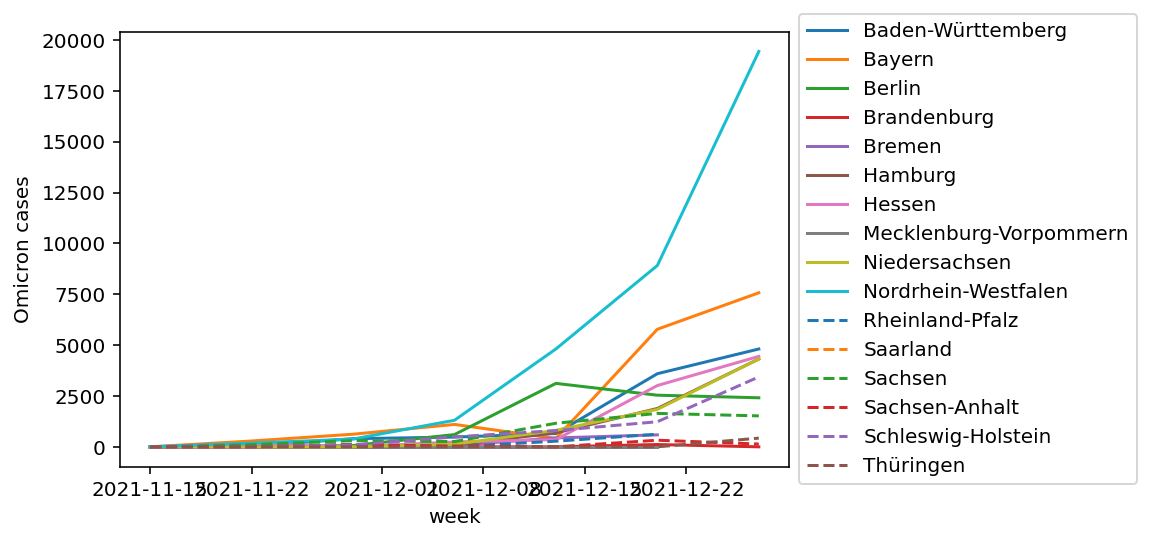

In [82]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] * c['prop'], label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('week')
plt.ylabel("Omicron cases")

In [83]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   211    0 -1236           168           1896   
                  2021-11-22  1533    1 -3948           588           6636   
                  2021-11-29   903    6 -3360           588           6636   
                  2021-12-06   954    9 -2772           588           6636   
                  2021-12-13   709   12 -2184           588           6636   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-06   143    0  -924           189           2135   
                  2021-12-13   240    0  -728           189           2135   
                  2021-12-20   166    0  -532           189           2135   
                  2021-12-27    73    5  -336           189           2135   
                  2022-01-03     0    0   -60            54            610   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000652  
                  2021-11-29  0.006645  
                  2021-12-06  0.009434  
                  2021-12-13  0.016925  
...                                ...  
Thüringen         2021-12-06  0.000000  
                  2021-12-13  0.000000  
                  2021-12-20  0.000000  
                  2021-12-27  0.068493  
                  2022-01-03       NaN  

[128 rows x 6 columns]

In [84]:
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-06         667
                  2022-01-07         492
                  2022-01-08         403
                  2022-01-09         214
                  2022-01-10         151

[11141 rows x 1 columns]

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


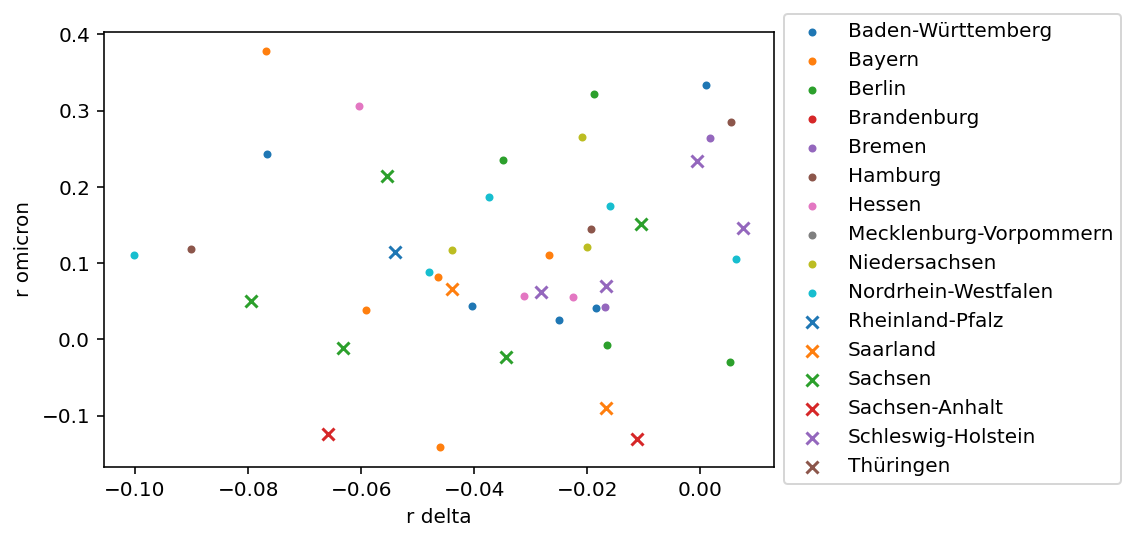

In [85]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    y = c['AnzahlFall'] * c['prop']
    x = c['AnzahlFall'] * (1-c['prop'])
    dx = np.log(x[1:]/x[:-1].values)/7
    dy = np.log(y[1:]/y[:-1].values)/7
    plt.scatter(dx, dy, label=r, marker = "." if i <10 else "x")
plt.xlabel("r delta")
plt.ylabel("r omicron")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [86]:
c = cases_land.loc[:,"2021-12-08":"2021-12-21",:] / cases_land.loc[:,"2021-12-01":"2021-12-14",:].values
foo = np.log(c).mean(level=0).rename(columns={'AnzahlFall':'r'}) / 7
foo['r_sd'] = np.log(c).std(level=0).values / 7

In [87]:
foo = foo.merge(pdf, left_index=True, right_index=True)

<AxesSubplot:xlabel='r', ylabel='s'>

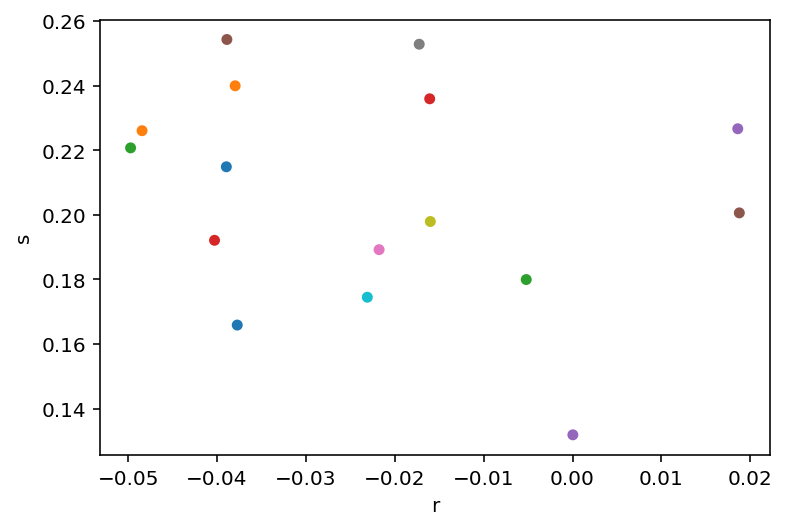

In [88]:
foo.plot.scatter("r","s", c = [f'C{i}' for i in range(foo.shape[0])])
#plt.legend()

Text(0, 0.5, 'Growth rate Omicron')

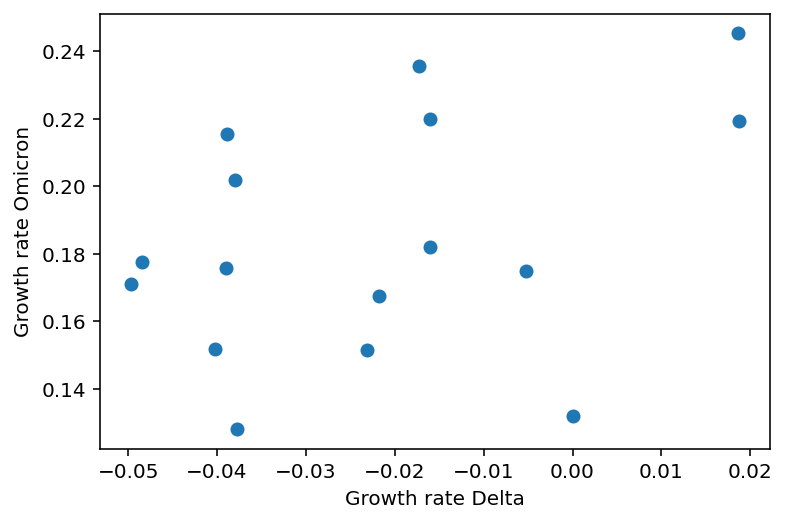

In [89]:
plt.scatter(foo['r'], foo['s'] + foo['r'])
plt.xlabel("Growth rate Delta")
plt.ylabel("Growth rate Omicron")

In [90]:
foo.to_csv(f"Germany_SGTF_{np.datetime64('today')}.csv")

In [91]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [92]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

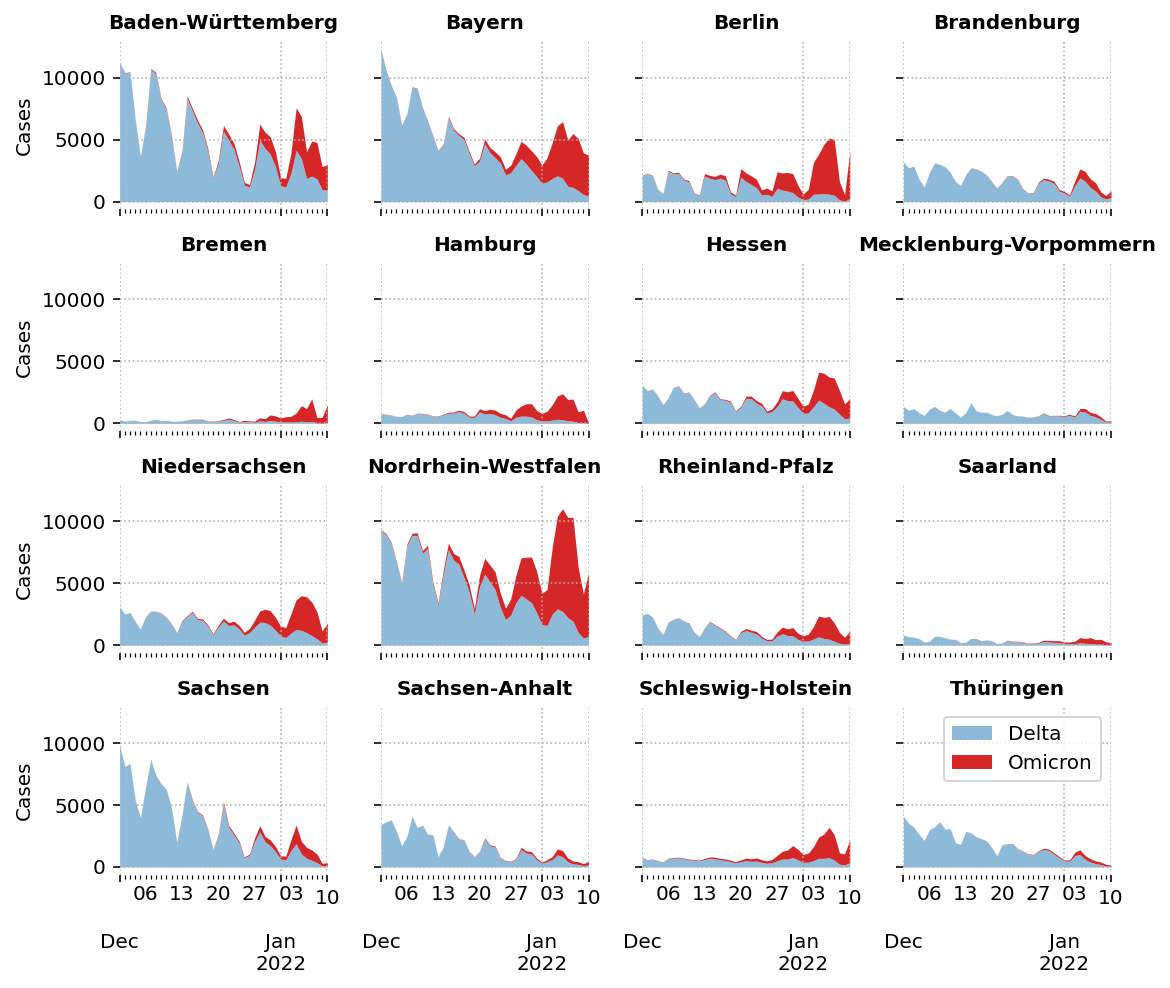

In [97]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] 
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = ((1-x[0.5]) * y)
    s = pd.Series(np.exp(lowess(np.log(z), z.index)[:,1]), z.dropna().index)
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    #ax[i].plot(s.index, s, ls="-", c='C0')
    #s.iloc[-7:-1]
    #ax[i].plot(x.index, s/(1-x[0.5]), ls="-", c='C3')
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()

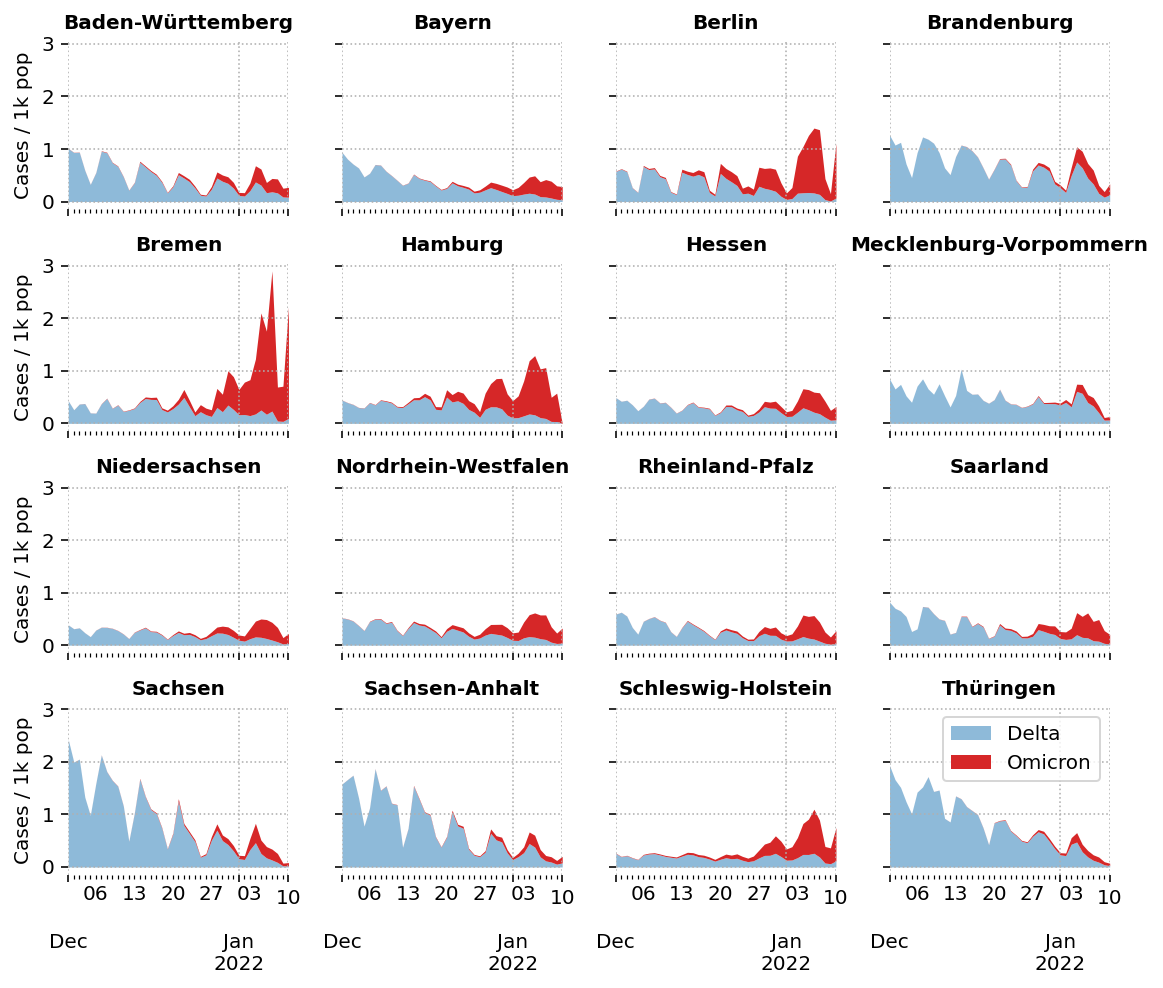

In [175]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = x[0.5] * y
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

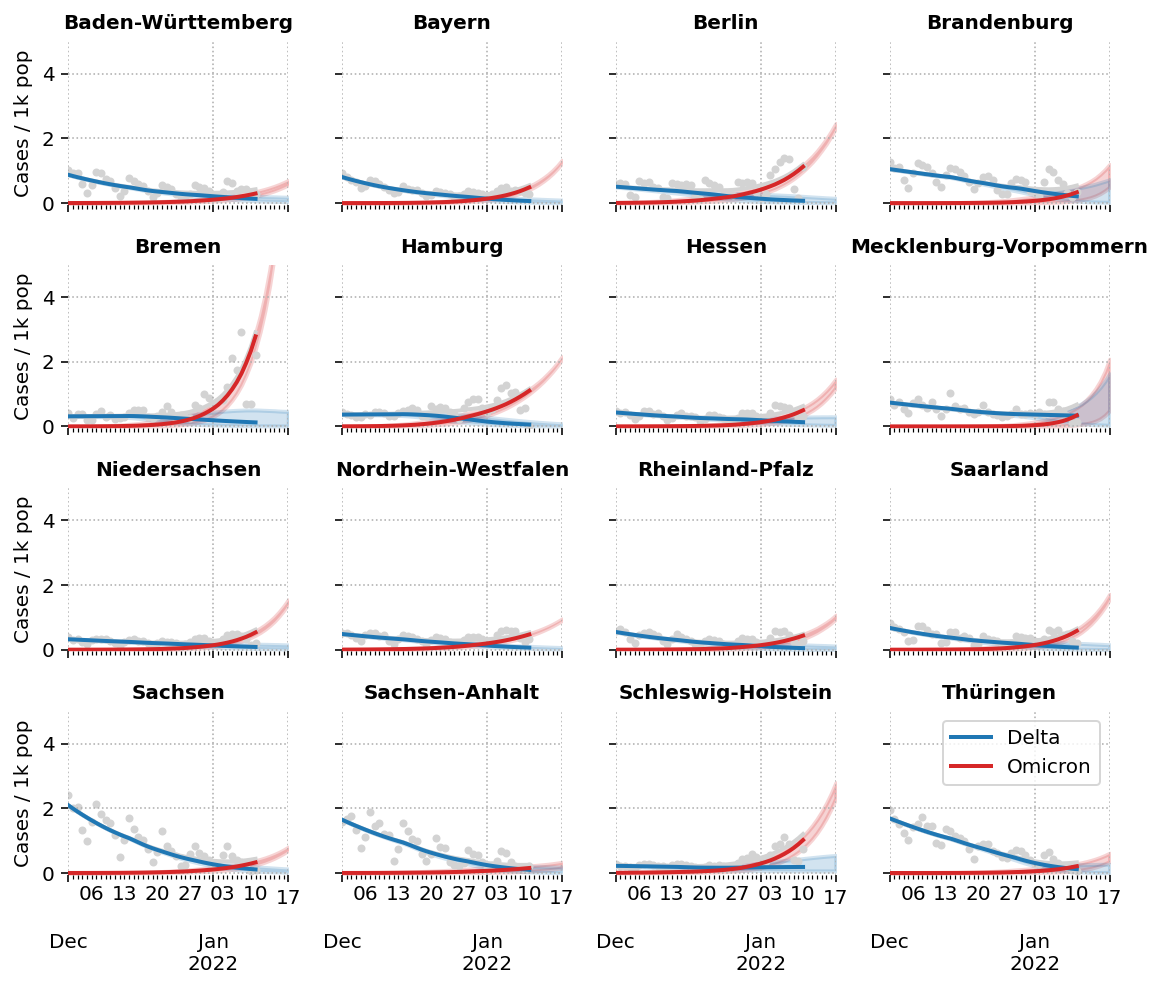

In [174]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
e = {}
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = ((1-x[0.5]) * y)
    s = pd.Series(np.exp(lowess(np.log(z), z.index)[:,1]), z.dropna().index)
    y.plot(ax=ax[i], ls="", label="")
    #ax[i].fill_between(s.index, s, color='C0', alpha=.5, lw=0, label="Delta")
    #ax[i].fill_between(x.index, s*x[0.5]/x[0.5], s/(1-x[0.5]), color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].plot(x.index, s/(1-x[0.5]), ls="-", c='lightgrey', label="", lw=2)
    ax[i].plot(s.index, s, ls="-", c='C0', label="Delta", lw=2)
    ax[i].plot(x.index, s/(1-x[0.5]) * x[.5], ls="-", c='C3', label="Omicron", lw=2)
    
    s1 = pd.Series(np.exp(np.log(s).diff().iloc[-7:].mean() * np.arange(1,8) + np.log(s)[-1]), index=s.index[-1] + np.arange(1,8).astype("timedelta64[D]"))
    #ax[i].plot(x.index, s1/(1-x[0.5]), ls=":", c='lightgrey', label="", lw=2)
    #ax[i].plot(s1.index, s1, ls=":", c='C0', label="", lw=2)
    #ax[i].plot(x.index, s1/(1-x[0.5]) * x[.5], ls=":", c='C3', label="", lw=2)
    
    s = pd.concat([s,s1])
    ax[i].fill_between(x.index, s/(1-x[0.5]) * x[0.05] , s/(1-x[0.5]) * x[0.95], color='C3', lw=2, alpha=0.2)
    ax[i].fill_between(x.index, s/(1-x[0.5]) * (1-x[0.05]) , s/(1-x[0.5]) * (1-x[0.95]) , color='C0', lw=2, alpha=0.2)

    
    ax[i].scatter(y.index, y, marker=".",c='lightgrey', label="")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    ax[i].set_xlim((None, s1.index[-1]))
    ax[i].set_ylim((None, 5))
    for a in ax[i].spines.values():
        a.set_visible(False)
    e[r] = s/(1-x[0.5][s.index]) * capita[r] / 1000
ax[-1].legend(title=None)
plt.tight_layout()
fig.savefig("plots/omi_abs_by_area_fit.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [155]:
pd.DataFrame(e).sum(1)

2021-12-01     60361.320573
2021-12-02     58063.509918
2021-12-03     55864.902069
2021-12-04     53756.498320
2021-12-05     51730.001645
2021-12-06     49781.291032
2021-12-07     47912.448106
2021-12-08     46129.378343
2021-12-09     44436.789036
2021-12-10     42836.995471
2021-12-11     41332.677447
2021-12-12     39927.855296
2021-12-13     38634.536804
2021-12-14     37456.973603
2021-12-15     36062.391345
2021-12-16     34615.371368
2021-12-17     33198.268964
2021-12-18     31919.511593
2021-12-19     30855.630341
2021-12-20     29992.917706
2021-12-21     29246.904764
2021-12-22     28540.719461
2021-12-23     27860.548677
2021-12-24     27253.513429
2021-12-25     26799.329778
2021-12-26     26566.089886
2021-12-27     26579.973066
2021-12-28     26804.271661
2021-12-29     27033.360417
2021-12-30     27282.263112
2021-12-31     27693.801244
2022-01-01     28321.799006
2022-01-02     29227.062008
2022-01-03     30431.206403
2022-01-04     31976.035573
2022-01-05     33908